In [1]:
!pip3 install uproot

In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc

In [3]:
def count_pt_range_alt(filename, ptmin=7, ptmax=10):
    with uproot.open(filename) as f:
        print("Upper level keys:", f.keys())
        tree = f["treeMLDstar"]
        pt_vals = tree.arrays(["fPt"], library="np")["fPt"]

    total_events = pt_vals.size
    in_range = np.logical_and(pt_vals > ptmin, pt_vals < ptmax)
    selected_events = in_range.sum()

    return total_events, selected_events


file_map = [
    ("Prompt",     "Prompt_DstarToD0Pi.root"),
    ("Nonprompt",  "Nonprompt_DstarToD0Pi.root"),
    ("Background", "Bkg_DstarToD0Pi.root"),
]

for name, path in file_map:
    tot, sel = count_pt_range_alt(path)
    print(f"{name:12s} | Total: {tot:9d} | 7<pT<10: {sel:9d}")


Upper level keys: ['treeMLDstar;1']
Prompt       | Total:    797119 | 7<pT<10:     96428
Upper level keys: ['treeMLDstar;1']
Nonprompt    | Total:    988954 | 7<pT<10:    121475
Upper level keys: ['treeMLDstar;1']
Background   | Total:  11163103 | 7<pT<10:    384437


In [4]:
# Fixed analysis settings
PT_WINDOW = (7, 10)
NSAMPLE = 50_000

SAMPLES = [
    ("Prompt",     "Prompt_DstarToD0Pi.root"),
    ("Nonprompt",  "Nonprompt_DstarToD0Pi.root"),
    ("Background", "Bkg_DstarToD0Pi.root"),
]


def plot_variable(branch, xlabel=None, bins=60):
    """
    Draw normalized histograms for a given branch
    after applying a pT window and equal subsampling.
    """

    rng = np.random.default_rng()
    selected_data = {}

    for tag, path in SAMPLES:
        with uproot.open(path) as f:
            tree = f["treeMLDstar"]
            arr = tree.arrays([branch, "fPt"], library="np")

        pt = arr["fPt"]
        var = arr[branch]

        pt_mask = np.logical_and(pt > PT_WINDOW[0], pt < PT_WINDOW[1])
        filtered = var[pt_mask]

        if filtered.shape[0] < NSAMPLE:
            raise RuntimeError(
                f"{tag}: insufficient statistics for {branch}"
            )

        pick = rng.choice(filtered.shape[0], size=NSAMPLE, replace=False)
        selected_data[tag] = filtered[pick]

    # ---- plotting ----
    fig, ax = plt.subplots(figsize=(8, 6))

    for tag, vals in selected_data.items():
        ax.hist(
            vals,
            bins=bins,
            density=True,
            histtype="step",
            linewidth=2,
            label=tag,
        )

    ax.set_xlabel(xlabel or branch)
    ax.set_ylabel("Normalized candidate density")
    ax.set_title(f"{branch} distribution (7<pT< 10 GeV/c)")
    ax.legend()
    ax.grid(True)

    plt.show()


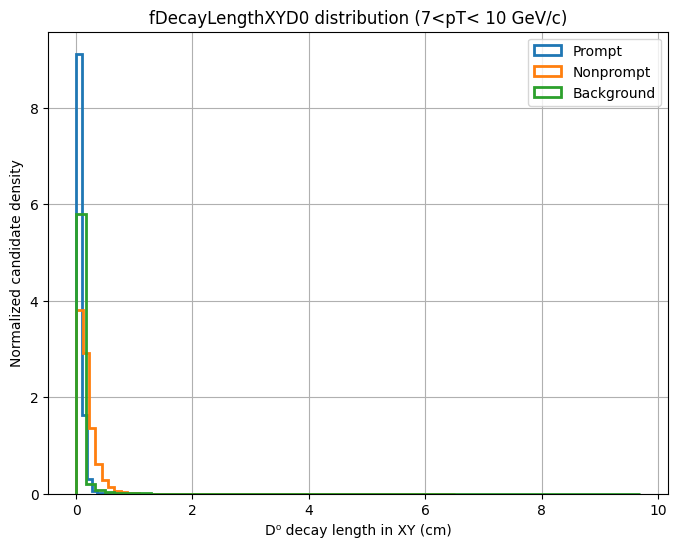

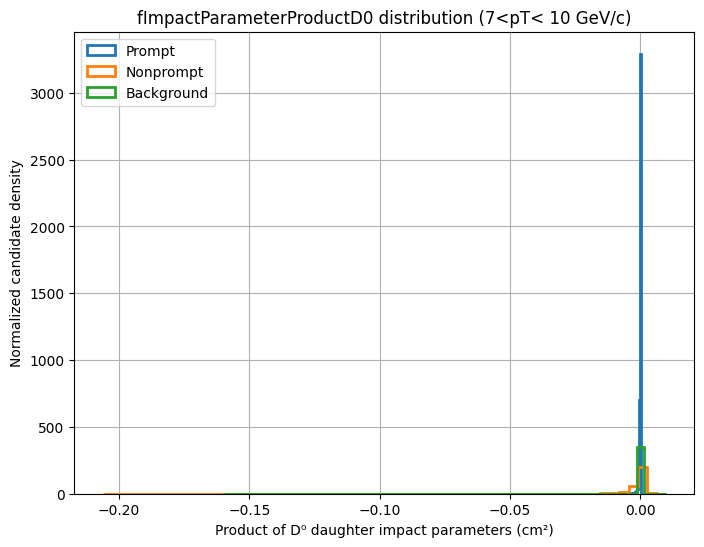

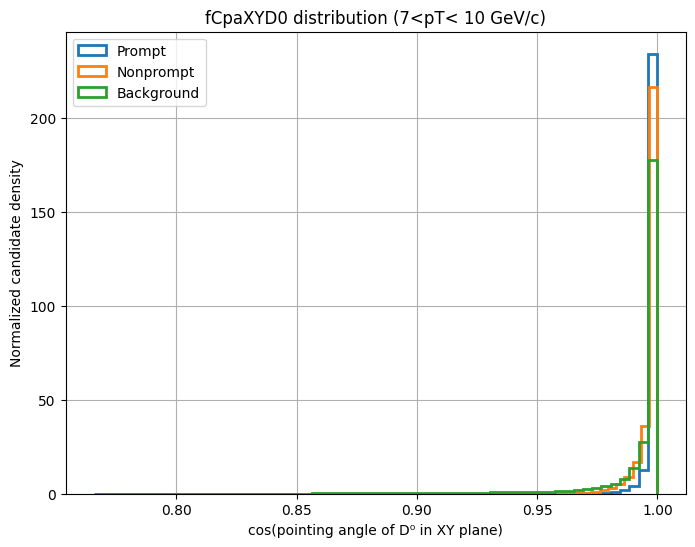

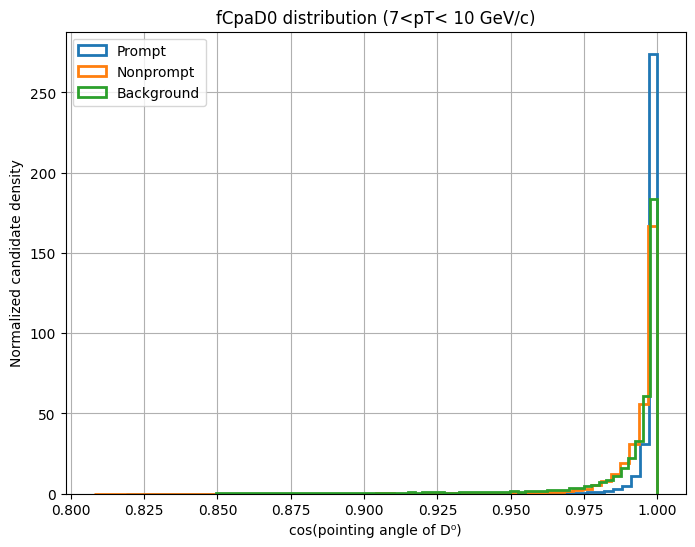

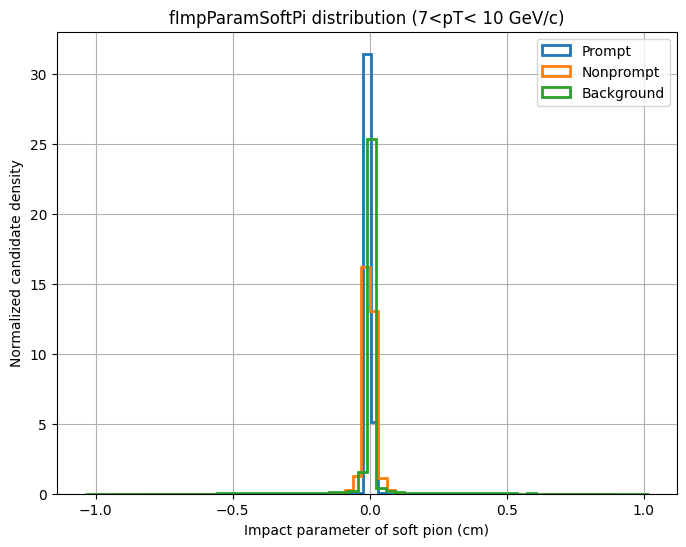

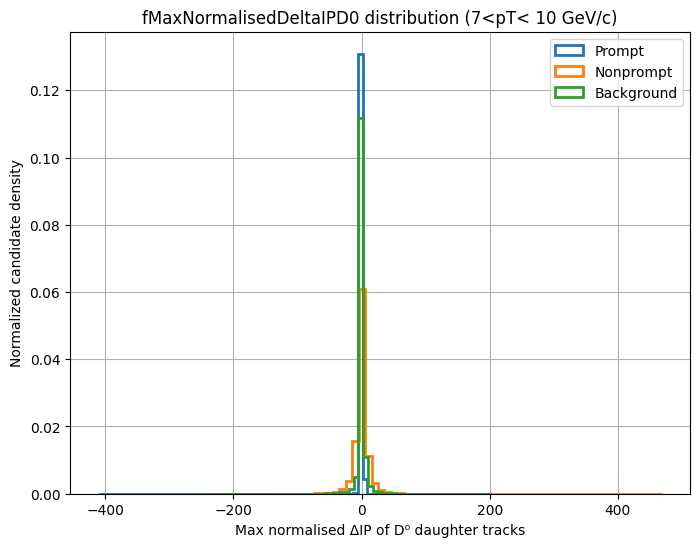

In [5]:
plot_variable("fDecayLengthXYD0", xlabel="D⁰ decay length in XY (cm)")
plot_variable(
    "fImpactParameterProductD0",
    xlabel="Product of D⁰ daughter impact parameters (cm²)"
)
plot_variable("fCpaXYD0", xlabel="cos(pointing angle of D⁰ in XY plane)")
plot_variable("fCpaD0", xlabel="cos(pointing angle of D⁰)")
plot_variable(
    "fImpParamSoftPi",
    xlabel="Impact parameter of soft pion (cm)"
)
plot_variable(
    "fMaxNormalisedDeltaIPD0",
    xlabel="Max normalised ΔIP of D⁰ daughter tracks"
)


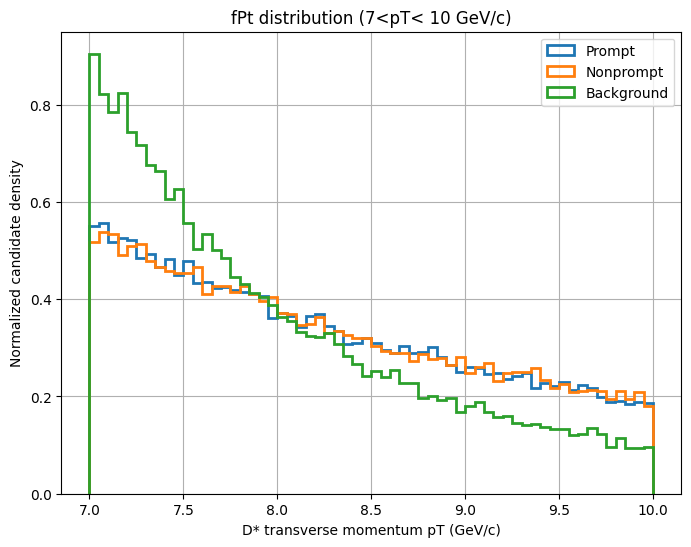

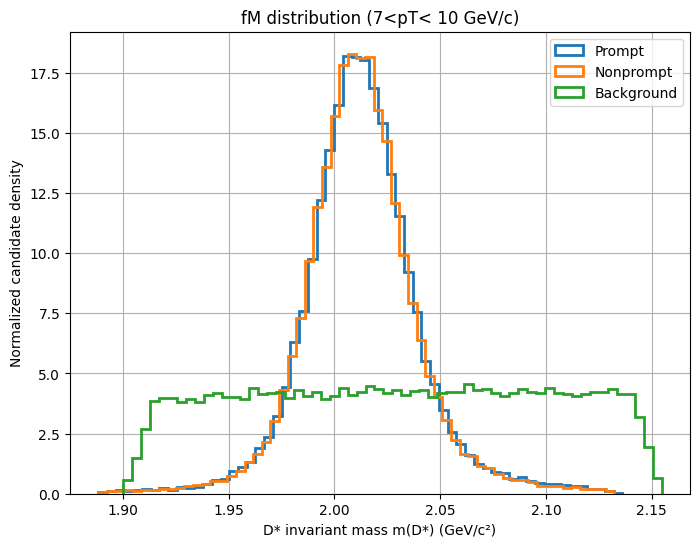

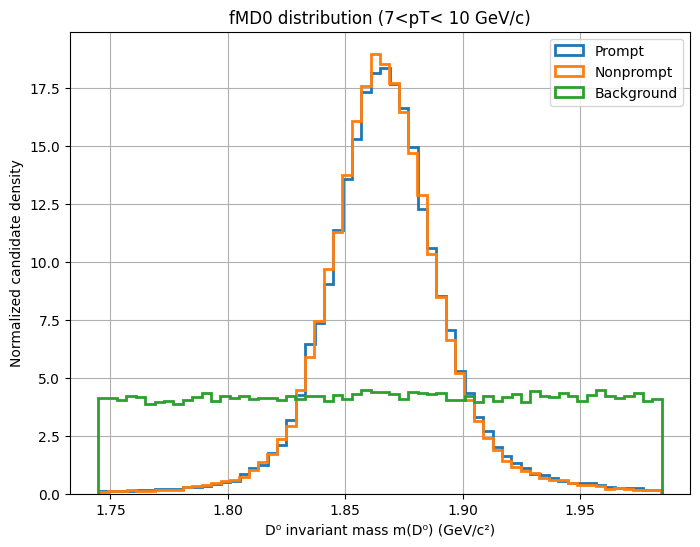

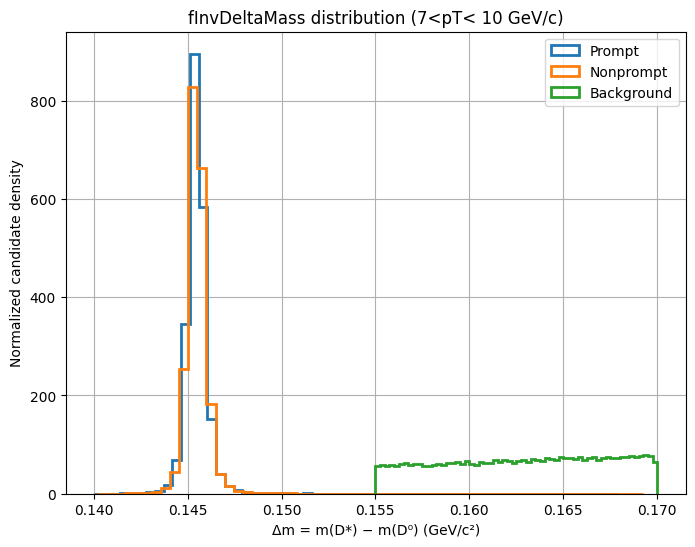

In [6]:
plot_variable("fPt", "D* transverse momentum pT (GeV/c)")
plot_variable("fM", "D* invariant mass m(D*) (GeV/c²)")
plot_variable("fMD0", "D⁰ invariant mass m(D⁰) (GeV/c²)")
plot_variable("fInvDeltaMass", "Δm = m(D*) − m(D⁰) (GeV/c²)")

In [7]:
# Open ROOT files
files = {
    "prompt":     "Prompt_DstarToD0Pi.root",
    "nonprompt":  "Nonprompt_DstarToD0Pi.root",
    "background": "Bkg_DstarToD0Pi.root",
}

trees = {}

for key, path in files.items():
    f = uproot.open(path)
    trees[key] = f["treeMLDstar"]

tree_prompt    = trees["prompt"]
tree_nonprompt = trees["nonprompt"]
tree_bkg       = trees["background"]


In [8]:
# Topological variables + pT for selection
TOPO_VARS = [
    "fCpaD0",
    "fCpaXYD0",
    "fDecayLengthXYD0",
    "fImpactParameterProductD0",
    "fImpParamSoftPi",
    "fMaxNormalisedDeltaIPD0",
    "fPt"   # required for pT cut
]

# Read arrays from each class
data_prompt    = tree_prompt.arrays(TOPO_VARS, library="np")
data_nonprompt = tree_nonprompt.arrays(TOPO_VARS, library="np")
data_bkg       = tree_bkg.arrays(TOPO_VARS, library="np")


def filter_pt(arrays, low=7, high=10):
    pt = arrays["fPt"]
    keep_mask = np.logical_and(pt > low, pt < high)

    out = {}
    for name in TOPO_VARS:
        out[name] = arrays[name][keep_mask]

    return out


prompt_cut    = filter_pt(data_prompt)
nonprompt_cut = filter_pt(data_nonprompt)
bkg_cut       = filter_pt(data_bkg)

# Stack all categories together variable-wise
merged_data = {}

for name in TOPO_VARS:
    merged_data[name] = np.hstack(
        (
            prompt_cut[name],
            nonprompt_cut[name],
            bkg_cut[name],
        )
    )

df = pd.DataFrame.from_dict(merged_data)


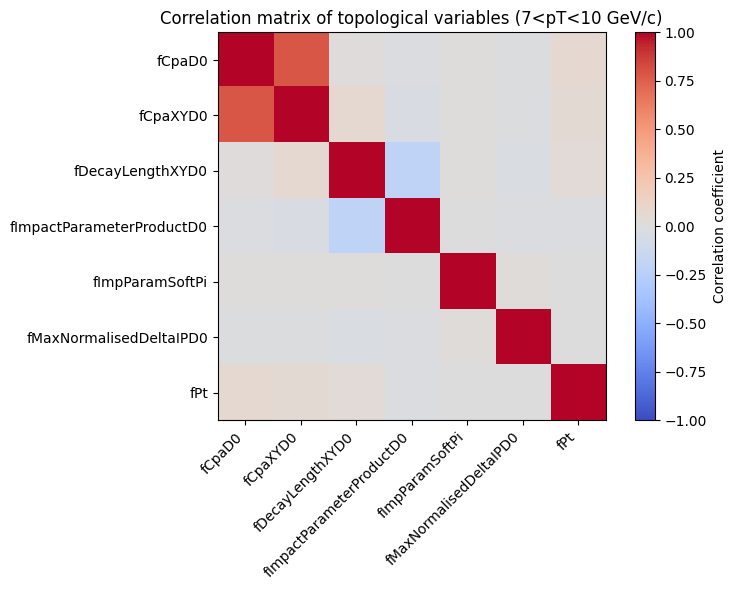

In [9]:
corr = df.corr()

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
im = plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, label="Correlation coefficient")

labels = df.columns
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.yticks(range(len(labels)), labels)

plt.title("Correlation matrix of topological variables (7<pT<10 GeV/c)")
plt.tight_layout()
plt.show()

In [10]:
FEATURE_SET = [
    "fCpaD0",
    "fCpaXYD0",
    "fDecayLengthXYD0",
    "fImpactParameterProductD0",
    "fImpParamSoftPi",
    "fMaxNormalisedDeltaIPD0",
]

def make_xy(arrays, class_id, pt_lo=7, pt_hi=10):
    pt_vals = arrays["fPt"]
    select = np.logical_and(pt_vals > pt_lo, pt_vals < pt_hi)

    cols = []
    for name in FEATURE_SET:
        cols.append(arrays[name][select])

    X_out = np.stack(cols, axis=1)
    y_out = np.repeat(class_id, X_out.shape[0])

    return X_out, y_out


# Class encoding: 0 = Background, 1 = Prompt, 2 = Nonprompt
Xp, yp = make_xy(data_prompt, 1)
Xn, yn = make_xy(data_nonprompt, 2)
Xb, yb = make_xy(data_bkg, 0)

X = np.concatenate((Xp, Xn, Xb), axis=0)
y = np.hstack((yp, yn, yb))


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=23,
    stratify=y
)

In [12]:
clf = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    max_depth=4,
    n_estimators=200,
    learning_rate=0.10,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    random_state=23,
)

# Train model
clf.fit(X_train, y_train)

# Class–probability predictions on the test sample
y_score = clf.predict_proba(X_test)

# Separate probabilities by ground-truth label
scores_bkg       = y_score[y_test == 0]
scores_prompt    = y_score[y_test == 1]
scores_nonprompt = y_score[y_test == 2]


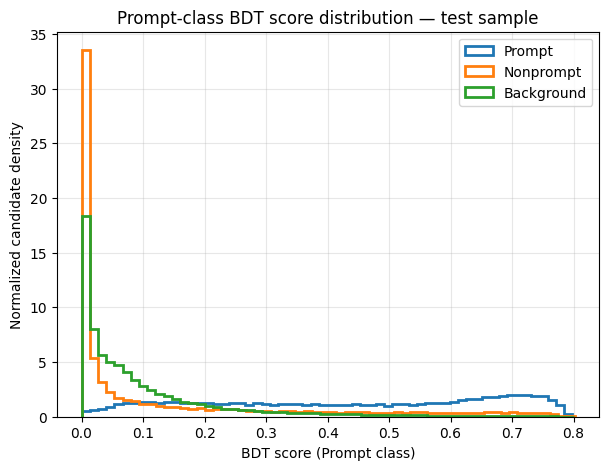

In [13]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.hist(
    scores_prompt[:, 1],
    bins=60,
    density=True,
    histtype="step",
    linewidth=2,
    label="Prompt",
)
ax.hist(
    scores_nonprompt[:, 1],
    bins=60,
    density=True,
    histtype="step",
    linewidth=2,
    label="Nonprompt",
)
ax.hist(
    scores_bkg[:, 1],
    bins=60,
    density=True,
    histtype="step",
    linewidth=2,
    label="Background",
)

ax.set_xlabel("BDT score (Prompt class)")
ax.set_ylabel("Normalized candidate density")
ax.set_title("Prompt-class BDT score distribution — test sample")
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()


In [14]:
# Keep only Background and Prompt samples
keep = np.isin(y_test, [0, 2])

# Binary truth: Prompt → 1, Background → 0
y_pb = np.where(y_test[keep] == 2, 1, 0)

# Prompt-class probability
score_pb = y_score[keep][:, 2]

fpr_pb, tpr_pb, thr_pb = roc_curve(y_pb, score_pb)
auc_pb = auc(fpr_pb, tpr_pb)


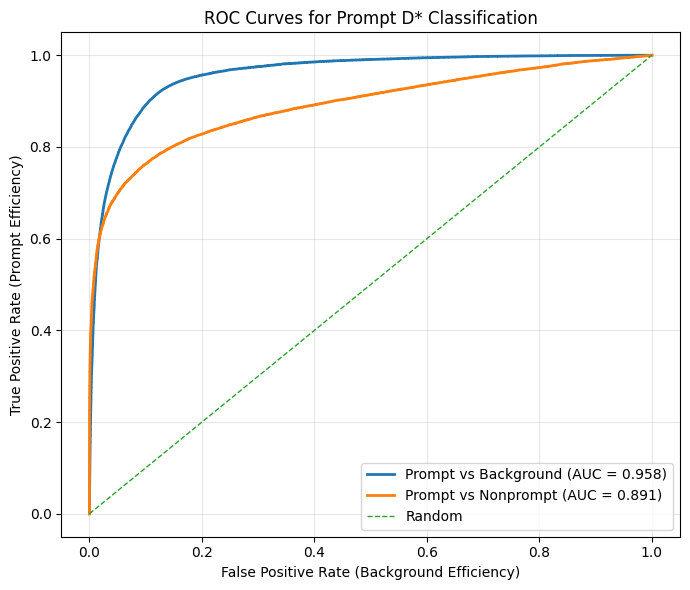

In [15]:
# Prompt vs Nonprompt selection
keep_pnp = np.isin(y_test, [1, 2])

# Binary labels: Prompt → 1, Nonprompt → 0
y_bin_pnp = np.where(y_test[keep_pnp] == 2, 1, 0)
score_pnp = y_score[keep_pnp][:, 2]

fpr_pnp, tpr_pnp, thresholds_pb = roc_curve(y_bin_pnp, score_pnp)
auc_pnp = auc(fpr_pnp, tpr_pnp)

# ---- Plotting ----
fig, ax = plt.subplots(figsize=(7, 6))

ax.plot(
    fpr_pb,
    tpr_pb,
    linewidth=2,
    label=f"Prompt vs Background (AUC = {auc_pb:.3f})",
)

ax.plot(
    fpr_pnp,
    tpr_pnp,
    linewidth=2,
    label=f"Prompt vs Nonprompt (AUC = {auc_pnp:.3f})",
)

ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1, label="Random")

ax.set_xlabel("False Positive Rate (Background Efficiency)")
ax.set_ylabel("True Positive Rate (Prompt Efficiency)")
ax.set_title("ROC Curves for Prompt D* Classification")
ax.legend()
ax.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()


In [16]:
# Desired prompt efficiency
eff_target = 0.75

# Distance from target efficiency
dist = np.abs(tpr_pb - eff_target)
best_idx = dist.argmin()

cut_value = thresholds_pb[best_idx]

print(f"Selected BDT threshold = {cut_value:.4f}")
print(f"Prompt efficiency ~ {tpr_pb[best_idx]:.3f}")
print(f"Background efficiency ~ {fpr_pb[best_idx]:.3f}")


Selected BDT threshold = 0.2466
Prompt efficiency ~ 0.750
Background efficiency ~ 0.041


In [17]:
# Extract prompt-class score
score_prompt = y_score[:, 2]

# Apply threshold
is_selected = score_prompt > cut_value

# Class-wise efficiencies on test sample
prompt_efficiency = is_selected[y_test == 2].sum() / (y_test == 2).sum()
nonprompt_efficiency = is_selected[y_test == 1].sum() / (y_test == 1).sum()
background_efficiency = is_selected[y_test == 0].sum() / (y_test == 0).sum()

print(f"Prompt efficiency     : {prompt_efficiency:.3f}")
print(f"Nonprompt efficiency  : {nonprompt_efficiency:.3f}")
print(f"Background efficiency : {background_efficiency:.3f}")


Prompt efficiency     : 0.834
Nonprompt efficiency  : 0.214
Background efficiency : 0.069
